In [224]:
import numpy as np
from PIL import Image
from sklearn import metrics
import matplotlib.pyplot as plt

# Read Data

### Train Data

Read the images from the Train folder and convert it to a numpy 1D array

In [225]:
def read_train_images():
    images = []
    for i in range(2400):
        img = Image.open('./Train/' + str(i + 1) + '.jpg')
        img = np.array(img).flatten()
        images.append(img)
    return images

Read the train labels from the Train folder

In [226]:
def read_train_labels():
    labels = []
    with open('./Train/Training Labels.txt') as f:
        for line in f:
            labels.append(int(line))
    return labels

### Test Data

Read the images from the Test folder and convert it to a numpy 1D array

In [227]:
def read_test_images():
    images = []
    for i in range(200):
        img = Image.open('./Test/' + str(i + 1) + '.jpg')
        img = np.array(img).flatten()
        images.append(img)
    return images

Read the train labels from the Test folder

In [228]:
def read_test_labels():
    labels = []
    with open('./Test/Test Labels.txt') as f:
        for line in f:
            labels.append(int(line))
    return labels

# Compute

## Mean

The function calculates the mean of each `image` in images, grouped by its corresponding `label` in labels.

The initialized array `mean` of size (10, 784) corresponds to number of classes (10), and number of features of each image (28*28).

$$m_i = \frac{\sum_{j=1}^{n} x_j}{n}$$

In [229]:
def compute_mean(images, labels):
    mean = np.zeros((10, 784))
    for i in range(10):
        for j in range(len(images)):
            if labels[j] == i:
                mean[i] += images[j]
        mean[i] /= labels.count(i)
    return mean

## Compute $S_i$ and $S_w$

A function that takes in three arguments: a list of train images, a list of train labels, and an array of means. The function calculates the *scatter matrix* of the images, grouped by their corresponding labels.

$$S_i = \sum_{j=1}^{n} (x_j - m_i)(x_j - m_i)^T$$

In [230]:
def compute_S(images, labels, mean):
    S = np.zeros((10, 784, 784))
    for i in range(10):
        for j in range(len(images)):
            if labels[j] == i:
                S[i] += np.dot((images[j] - mean[i]).reshape(784, 1), (images[j] - mean[i]).reshape(1, 784))
    return S

The function takes an the scatter matrix, which was computed in the previous step (by calling `compute_S` function), calculated the total variance ($S_w$) and returns the inverse of it

In [231]:
def compute_Sw_inv(s):
    Sw = np.sum(s, axis=0)
    Sw_inv = np.linalg.pinv(Sw)
    return Sw_inv

## Fisher's Linear Discriminant

The function takes the $S_w$ and means calculated in the previous steps and calculated the Fisher's Linear Discriminant for each group of images.

$$w_i = S_w^{-1}(m_{others}-m_i)$$

In [232]:
def compute_fisher_linear_discriminant(Sw_inverse, mean):
    w = np.zeros((10, 784))
    for i in range(10):
        w[i] = np.dot(Sw_inverse, mean[i])
    return w

## Compute Bias ($w_0$)

The function takes two arguments, the computed fisher linear discriminant and the mean.

$$w_{0, i} = -\frac{1}{2}w_i^T(m_i + m_{other})$$

In [233]:
def compute_w0(w, mean):
    w0 = np.zeros(10)
    for i in range(10):
        w0[i] = -0.5 * np.dot(w[i].T, mean[i])
    return w0

## Classify

The function optionally takes in an additional argument w0 which is the bias for the prediction.

$$Y(x)=w^Tx_i+w_0$$
or
$$Y_{i,j} = w_j^Tx_i + w_{0,j}$$

In [234]:
def classify_fisher_linear_discriminant(images, w, w0=None):
    Y = np.zeros((len(images), 10))
    predict = np.zeros((len(images)), dtype=int)

    for i in range(len(images)):
        for j in range(10):
            if w0 is None:
                Y[i][j] = np.dot(w[j], images[i])
            else:
                Y[i, j] = np.dot(w[j].T, images[i]) + w0[j]

        predict[i] = np.argmax(Y[i])

    return predict

## Accuracy

A function that takes in two arguments: a list of predicted labels and a list of true labels. The function calculates the accuracy of the predictions by comparing the predicted labels to the true labels.

In [235]:
def compute_accuracy(labels, test_labels):
    correct = 0
    for i in range(len(labels)):
        if labels[i] == test_labels[i]:
            correct += 1
    return correct / len(labels)

## Confusion Matrix

Generates, displays, and saves the confusion matrix. Takes 3 arguments: a list of predicted labels, a list of true labels, and a file name in which the generated matrix will be saved as.

In [236]:
def compute_confusion_matrix(labels, test_labels, filename):
    confusion_matrix = metrics.confusion_matrix(labels, test_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot()
    plt.savefig(filename)

# Testing

Read all the data

In [237]:
train_images = read_train_images()
train_labels = read_train_labels()
test_images = read_test_images()
test_labels = read_test_labels()

Calculate means and $S_w$

In [238]:
means = compute_mean(train_images, train_labels)
S = compute_S(train_images, train_labels, means)
Sw_inv = compute_Sw_inv(S)

Calculate Fisher's Linear Discriminant and Bias

In [239]:
w = compute_fisher_linear_discriminant(Sw_inv, means)
w0 = compute_w0(w, means)

Predict values

In [240]:
prediction = classify_fisher_linear_discriminant(test_images, w)
prediction_bias = classify_fisher_linear_discriminant(test_images, w, w0)

Test accuracy

In [241]:
accuracy = compute_accuracy(prediction, test_labels)
accuracy_bias = compute_accuracy(prediction_bias, test_labels)

print('Accuracy without bias: ', accuracy)
print('Accuracy with bias: ', accuracy_bias)

Accuracy without bias:  0.79
Accuracy with bias:  0.825


Generate confusion matrix

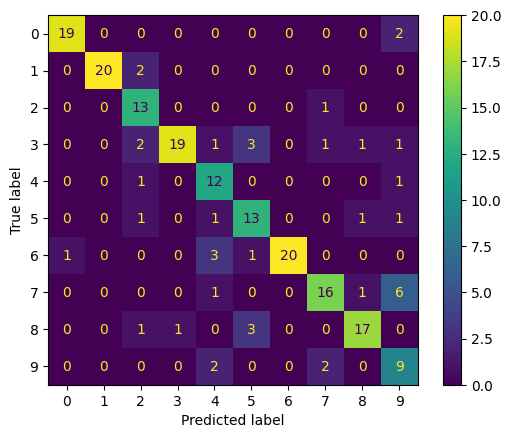

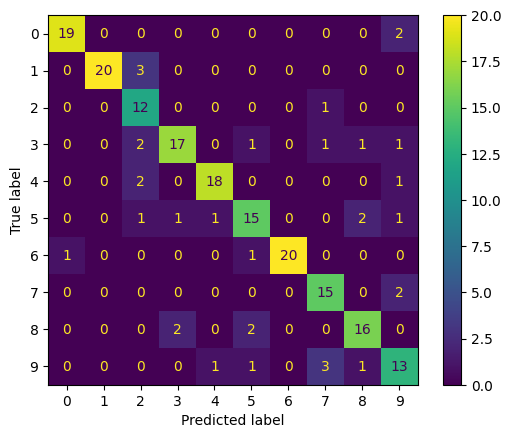

In [242]:
compute_confusion_matrix(prediction, test_labels, 'ConfusionNoBias')
compute_confusion_matrix(prediction_bias, test_labels, 'ConfusionWithBias')

# Conclusion

Without a bias term, the decision boundary will always pass through the origin, which may not be optimal for separating the classes in all cases. By introducing a bias, we can adjust the position of the decision boundary to better fit the data and improve the classification accuracy.

Introducing a bias term into the model in this project resulted in a 0.35% improvement in performance. While this may not seem like a significant improvement, in more complex projects, the impact of a bias term on the model's performance could be more noticeable. However, it's important to note that the use of a bias term can also introduce overfitting to the model if it is not used carefully.